

```
# This is formatted as code
```

# Imports and Seeding

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler
# TODO: seeding

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D
from google.colab import drive

Using TensorFlow backend.


# Mount Google Drive, Read Data

In [0]:
# This will mount your personal drive. Note you'll need to authenticate.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Google doesn't seem to currently support accessing a folder which is shared
# with you. So, I've uploaded 'all_data.csv' to my own drive. To run, you'll
# need to do the same.
# os.listdir('/content/drive/My Drive')
# TODO: Remove row limitation.
df = pd.read_csv('/content/drive/My Drive/all_data.csv', index_col=0, parse_dates=True,
                 infer_datetime_format=True) #, nrows=(1/5)*60*24*7*4)
# Why my 'tz_convert' line did nothing in combine_all_data.py, I don't know.
df.index = pd.to_datetime(df.index, utc=True)
# df.index = df.index.tz_localize('UTC')
df = df.tz_convert('America/New_York')
print('Data loaded.')

Data loaded.


In [0]:
print(df.head())
print(df.tail())
# print(df.info())
# Since our time is evenly spaced, linear interpolation should do.
# Why this didn't take in the script that created the file, I'm not sure.
df.interpolate(method='linear', inplace=True)
# After interpolation, there's just one NaN left. Use forward and backfilling.
df.fillna(method='ffill', inplace=True)
df.fillna(method='backfill', inplace=True)
# Confirm we got rid of all the NaNs.
nan_count = df.isna().sum()
nan_cols = nan_count > 0
print('Columns with NaNs:')
print(df.columns[nan_cols])
print('NaN counts:')
print(nan_count[nan_cols])

                           forecast_lbmp__capitl  forecast_lbmp__centrl  \
Time Stamp                                                                
2016-01-01 00:00:00-05:00                  30.19                  13.04   
2016-01-01 00:05:00-05:00                  30.19                  13.04   
2016-01-01 00:10:00-05:00                  30.19                  13.04   
2016-01-01 00:15:00-05:00                  30.19                  13.04   
2016-01-01 00:20:00-05:00                  30.19                  13.04   

                           forecast_lbmp__dunwod  forecast_lbmp__genese  \
Time Stamp                                                                
2016-01-01 00:00:00-05:00                  25.79                  12.45   
2016-01-01 00:05:00-05:00                  25.79                  12.45   
2016-01-01 00:10:00-05:00                  25.79                  12.45   
2016-01-01 00:15:00-05:00                  25.79                  12.45   
2016-01-01 00:20:00-05:0

# Split Data Into Testing vs. Training, Extract Feature We'll be Predicting

In [0]:
# Let's look at realtime LBMP in NYC.
y = df['realtime_lbmp__nyc']
x = df.drop(labels='realtime_lbmp__nyc', axis=1)

# TODO: We probably shouldn't be using real-time data in training/predicting,
# right? This should maybe be a two-step process: Predict 5-minute real-time 
# (will need another network/model to do that), then plug that in for LMP
# training/predicting.
y_train = y['2016':'2017']
y_test = y['2018']
x_train = x['2016':'2017']
x_test = x['2018']

print('Data split for train vs. test.')

Data split for train vs. test.


# Scale Data

In [0]:
# We'll use "standard" scaling
# Scale y data.
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
# 
scaler_x = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train.values)
x_test_scaled = scaler_x.transform(x_test.values)
print('Data has been scaled.')

# Ensure we have no NaNs.
np.isnan(x_train_scaled).any()

Data has been scaled.


False

# Create and Train Simple ANN

In [0]:
# This is just a silly simple ANN. Neurons per layer were selected with barely
# any thought (except that people tend to use numbers which are powers of 2).
ann = Sequential()
ann.add(Dense(x_train.shape[1], input_dim=x_train.shape[1], activation='relu'))
ann.add(Dense(256, activation='relu'))
ann.add(Dense(128, activation='relu'))
ann.add(Dense(64, activation='relu'))
ann.add(Dense(1))

ann.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
ann.fit(x_train_scaled, y_train_scaled, epochs=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
210528/210528 [==============================] - 27s 130us/step - loss: 0.1622 - mean_squared_error: 0.1622
Epoch 2/10
210528/210528 [==============================] - 25s 117us/step - loss: 0.0803 - mean_squared_error: 0.0803
Epoch 3/10
210528/210528 [==============================] - 26s 123us/step - loss: 0.0968 - mean_squared_error: 0.0968
Epoch 4/10
210528/210528 [==============================] - 25s 117us/step - loss: 0.0557 - mean_squared_error: 0.0557
Epoch 5/10
210528/210528 [==============================] - 25s 117us/step - loss: 0.0551 - mean_squared_error: 0.0551
Epoch 6/10
210528/210528 [==============================] - 26s 122us/step - loss: 0.0464 - mean_squared_error: 0.0464
Epoch 7/10
210528/210528 [==============================] - 26s 124us/step - loss: 0.0655 - mean_squared_error: 0.0655
Epoch 8/10
210528/210528 [=====================

# Predict with ANN

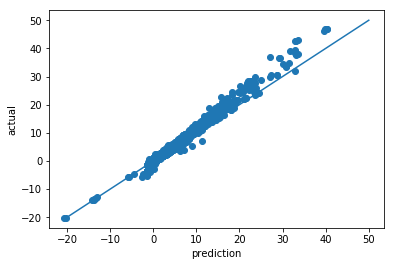

In [0]:
y_pred = ann.predict(x_test_scaled)

# NOTE:
# No parameter tuning, no stopping criterion, and we're not doing too badly. 

# TODO: Move this import - inline imports are poor form.
import matplotlib.pyplot as plt
plt.scatter(y_pred, y_test_scaled)
# If our predictions were perfect, they'd fall exactly on this line.
plt.plot([-20, 50], [-20,50])
plt.xlabel('prediction')
plt.ylabel('actual')
plt.show()

# To start, try a "simple" 1D CNN

In [0]:
# Benefit to the 1D CNN: We don't have to reshape our data in a complicated manner
# Cons: TBD

# TODO: Finish this up. Ran out of time :/ 
# In the section below (Reshape Data for 2D CNN) there are some useful 
# constants, etc. We may need to do some simple data reshaping for this 1D CNN,
# like arranging the data into batches. Take a look at what was done for the 
# section below. Note that here, we would likely just have to group the data
# into 4-week batches to pass in for convolution. To be honest, I'm not really
# sure how this 1D convolution works though.

# https://keras.io/layers/convolutional/
cnn1d = Sequential()
# Kernel size of 36 - 3 hours of 5 minute windows?
cnn1d.add(Conv1D(filters=32, kernel_size=36, padding='same', input_shape=()))
cnn1d.add(Flatten())
cnn1d.add(Dense(64, activation='relu'))
cnn1d.add(Dense())

# Reshape Data for 2D CNN

In [0]:
# TODO: revisit this and get it working. 2D convolutional would be quite 
# interesting.

# # How many full weeks do we have?
# five_min_per_week = int((1/5) * 60 * 24 * 7)
# # Given the shape of our data, how many weeks are there? (round down)
# weeks_train = np.floor(x_train_scaled.shape[0] / five_min_per_week).astype(int)
# weeks_test = np.floor(x_test_scaled.shape[0] / five_min_per_week).astype(int)
# # Given how many weeks we have and assuming we train with 4 week batches, how
# # many batches will we have?
# batches_train = int(np.floor(weeks_train) / 4)
# batches_test = int(np.floor(weeks_test) / 4)
# # Determine the ending index of the data we'll keep (trim off the end)
# keep_train = five_min_per_week * batches_train
# keep_test = five_min_per_week * batches_test

# # Trim the training and testing data.

# x_train_scaled_keep = x_train_scaled[0:keep_train, :]
# print('Trimmed traning data shape:')
# print(x_train_scaled_keep.shape)
# y_train_scaled_keep = y_train_scaled[0:keep_train]
# print(y_train_scaled_keep.shape)

# x_test_scaled_keep = x_test_scaled[0:keep_test, :]
# y_test_scaled_keep = y_test_scaled[0:keep_test]
# print(x_test_scaled_keep.shape)
# print(y_test_scaled_keep.shape)

# # Reshape the data!
# # Arrange the data so that we have (batch, height, width, channels). We'll first
# # try with one "month" batches, so we'll have "batches_train" or "batches_test"
# # of them. Each "month" is 4 weeks (the height) and has 2016 samples
# #(five_min_per_week). Finally, we'll have a channel for each feature.
# x_train_reshaped = np.zeros((batches_train, 4, five_min_per_week,
#                              x_train_scaled_keep.shape[1]))
# x_test_reshaped = np.zeros((batches_test, 4, five_min_per_week,
#                             x_test_scaled_keep.shape[1]))
# # TODO: how do we need to reshape the y's? Array of vectors? Row per "month"?

# # Time steps per 4 week month:
# t_per_m = five_min_per_week * 4

# # Loop over the features
# for f_idx in range(x_train_reshaped.shape[-1]):
#   # Loop over the "months".
#   for m_idx in range(batches_train):
#     # Determine starting and ending index:
#     start_idx = int(m_idx * t_per_m)
#     end_idx = start_idx + t_per_m
    
#     # Extract the relevant portions of the training data.
#     d_train = x_train_scaled_keep[start_idx:end_idx, f_idx]
    
#     # Reshape the training data.
#     d_train_reshaped = np.reshape(d_train, newshape=(4, five_min_per_week))
    
#     # Place the data into the reshaped array.
#     x_train_reshaped[m_idx, :, :, f_idx] = d_reshaped
    
#     # Repeat for the testing data. However, we'll bail if we get an index error.
#     try:
#       d_test = x_test_scaled_keep[start_idx:end_idx, f_idx]
      
#     except IndexError:
#       pass
#     else:
#       try:
#         d_test_reshaped = np.reshape(d_test, newshape=(4, five_min_per_week))
#         x_test_reshaped[m_idx, :, :, f_idx] = d_test_reshaped
#       except ValueError as e:
#         print('m_idx: {}, f_idx: {}'.format(m_idx, f_idx))
#         print('start_idx: {}, end_idx: {}'.format(start_idx, end_idx))
#         print('Shape of x_test_scaled_keep: {}'.format(x_test_scaled_keep.shape))
#         raise e
    
# print('Data reshaped.')

# Create 2D CNN

In [0]:
# TODO: This was left in an incomplete state.

# # If training is taking too long, we may want to switch to 'SeperableConv2D'
# # layers instead of simply Conv2D
# model = Sequential()
# # kernel size of 12, 4 will give us 12 5 minutes intervals and 4 weeks if the 
# # data is arranged in a weekly format.
# # 
# # Using strides of 3, 1 so we traverse 15 minutes of data at a time.
# model.add(Conv2D(filters=8, kernel_size=(12, 4), strides=(3, 1),
#                  padding='same', data_format='channels_last',
#                  input_shape=(4, five_min_per_week, x_train.shape[1])))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='relu'))

# model.compile(loss=keras.losses.mean_squared_error, optimizer='Adam',
#               metrics=['accuracy'])
# print(model.summary())

# Train CNN

In [0]:
# model.fit()